In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim


In [2]:
BATCH_SIZE= 32
torch.manual_seed(42)
transform= transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
train_dataset= torchvision.datasets.CIFAR10(root= './data', train= True, download= True, transform= transform)
test_dataset= torchvision.datasets.CIFAR10(root= './data', train= False, download= True, transform= transform)

train_loader= DataLoader(dataset= train_dataset, batch_size= BATCH_SIZE, shuffle= True)
test_loader= DataLoader(dataset= test_dataset, batch_size= BATCH_SIZE, shuffle= False)
class_names= train_dataset.classes


transform_aug= transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(
    brightness=0.5,  # Randomly adjust brightness by a factor between [max(0, 1-0.5), 1+0.5] = [0.5, 1.5]
    contrast=(0.8, 1.2),  # Randomly adjust contrast by a factor between 0.8 and 1.2
    saturation=0.3,  # Randomly adjust saturation by a factor between [max(0, 1-0.3), 1+0.3] = [0.7, 1.3]
    hue=(-0.1, 0.1))  # Randomly adjust hue by a factor between -0.1 and 0.1
])

train_aug_dataset= torchvision.datasets.CIFAR10(root= './data', train= True, download= True, transform= transform_aug)
test_aug_dataset= torchvision.datasets.CIFAR10(root= './data', train= False, download= True, transform= transform_aug)

train_aug_loader= DataLoader(dataset= train_dataset, batch_size= BATCH_SIZE, shuffle= True)
test_aug_loader= DataLoader(dataset= test_dataset, batch_size= BATCH_SIZE, shuffle= False)


100%|██████████| 170M/170M [00:04<00:00, 41.6MB/s]


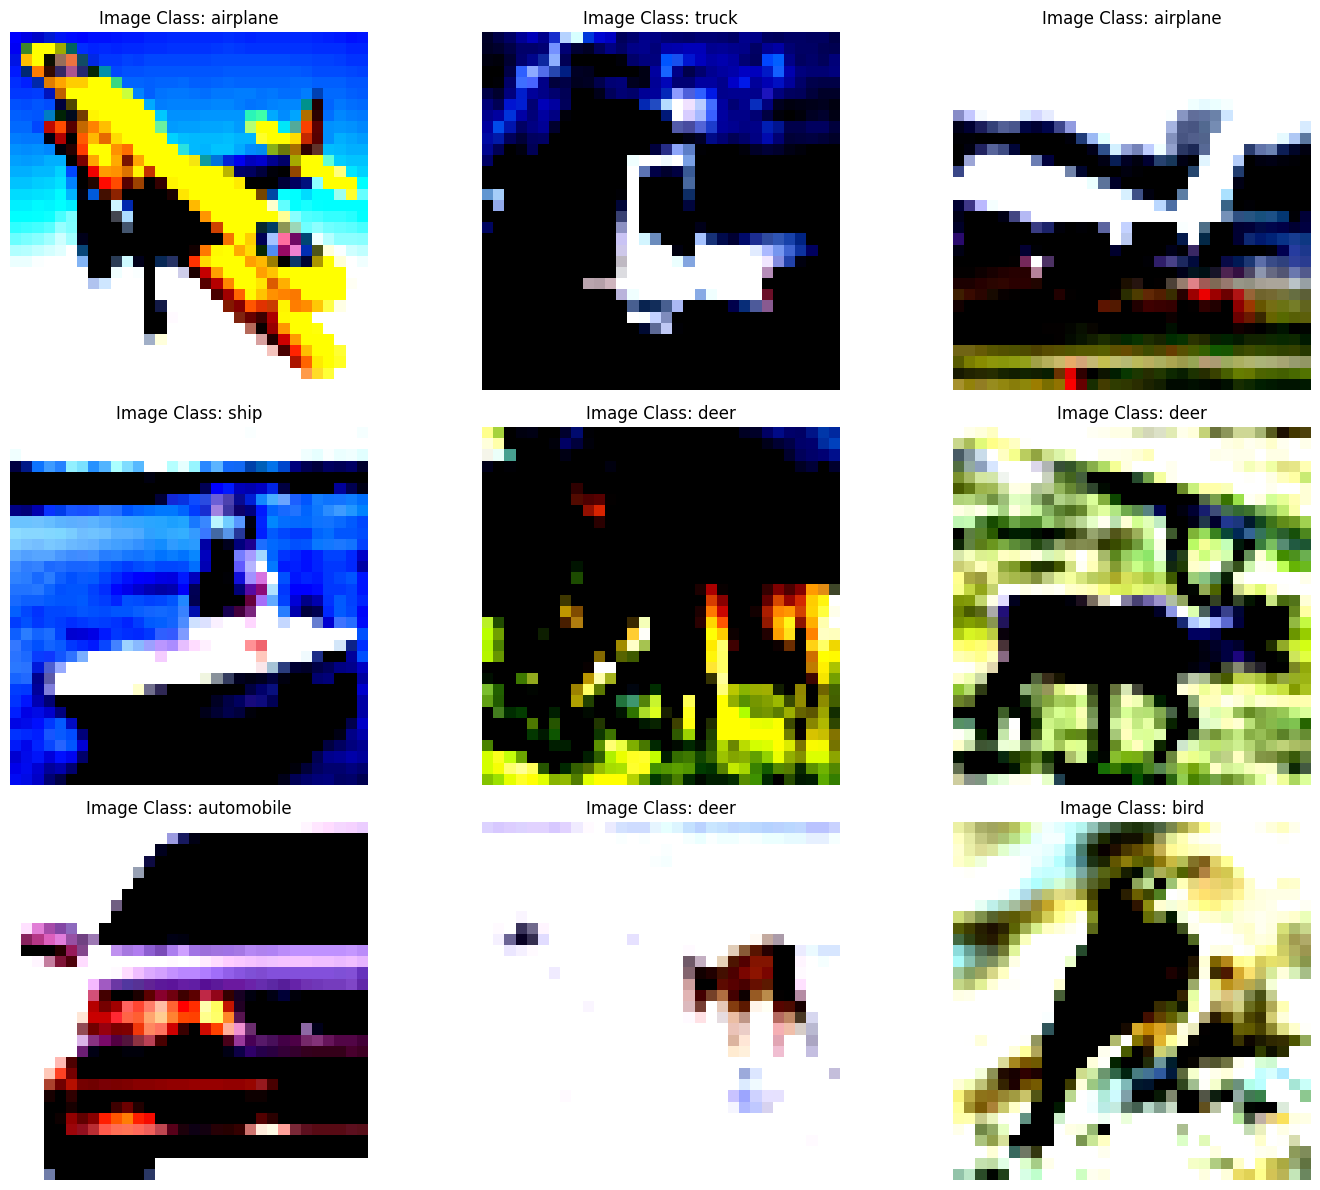

torch.Size([32, 3, 32, 32])

In [3]:
def display_images(images, labels, class_names, indices, n_rows= 3, n_cols= 3, figsize= (15,12)):
    fig, axes= plt.subplots(n_rows, n_cols, figsize= figsize)

    axes= axes.flatten()
    for i, idx in enumerate(indices):
        image= images[idx].permute(1,2,0).numpy()
        label= labels[idx].item()

        axes[i].imshow(image.squeeze())
        axes[i].axis(False)
        axes[i].set_title(f"Image Class: {class_names[label]}")
    plt.tight_layout()
    plt.show()
images, labels= next(iter(train_loader))
indices= [1,6, 16, 9, 7, 25, 29, 2, 4]
display_images(images, labels, class_names, indices)
images.shape

In [4]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv Block 1
        self.conv1= nn.Conv2d(in_channels= 3,
                              out_channels= 32,
                              kernel_size= 3,
                              stride= 1,
                              padding= 0) # Input Shape: (batch_size, 3, 32, 32) Output Shape: (batch_size, 32, 30, 30)
        self.relu1= nn.LeakyReLU(0.1)
        self.pool1= nn.MaxPool2d(kernel_size= 2) # Input Shape: (batch_size, 32, 30, 30) Output Shape: (batch_size, 32, 15, 15)
        self.dropout1= nn.Dropout(p= 0.2)

        # Conv Block 2
        self.conv2= nn.Conv2d(in_channels= 32,
                              out_channels= 64,
                              kernel_size= 3,
                              stride= 1,
                              padding= 0) # Input Shape: (batch_size, 32, 15, 15) Out: (batch_size, 64, 13, 13)
        self.relu2= nn.LeakyReLU(0.1)
        self.pool2= nn.MaxPool2d(kernel_size= 2) # Input Shape: (batch_size, 64, 13, 13) Out: (batch_size, 64, 6, 6)
        self.dropout2= nn.Dropout(p= 0.3)

        self.flatten= nn.Flatten()

        self.fc1= nn.Linear(64 * 6 * 6, 256)
        self.relu3= nn.LeakyReLU(0.1)
        self.dropout3= nn.Dropout(p= 0.4)
        self.output= nn.Linear(256, 10)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        self.activation_std_history= [] # List of Dicts: [{'fc1': std, ....}, ...]
        self.gradient_std_history= [] # Same for gradients


    def forward(self, x):
        # Feature Learning
        features= self.dropout1(self.pool1(self.relu1(self.conv1(x))))
        features= self.dropout2(self.pool2(self.relu2(self.conv2(features))))
        # Classification
        features= self.flatten(features)
        features= self.dropout3(self.relu3(self.fc1(features)))

        output= self.output(features)

        return output

    def register_std_hooks(self):
            # Temporary trackers for current pass
            self.activation_stds = {}
            self.gradient_stds = {}
            # Forward hook function (closure)
            def forward_hook(module, input, output):
                # Compute std of output activations (flatten to 1D for global std)
                layer_name= module.__class__.__name__
                if output.numel() > 1:  # Avoid std on empty/scalar tensors
                    std = torch.std(output.detach().view(-1)).item()
                    self.activation_stds[layer_name] = std
                else:
                    self.activation_stds[layer_name] = 0.0  # Fallback


            # Backward hook function (closure)
            def backward_hook(module, grad_input, grad_output):
                layer_name= module.__class__.__name__
                if grad_output[0] is not None and grad_output[0].numel() > 1:
                    std = torch.std(grad_output[0].detach().view(-1)).item()
                    self.gradient_stds[layer_name] = std
                else:
                    self.gradient_stds[layer_name] = 0.0  # Fallback



            # Register hooks on key layers
            self.fc1.register_forward_hook(forward_hook)
            self.fc1.register_full_backward_hook(backward_hook)

            self.relu3.register_forward_hook(forward_hook)
            self.relu3.register_full_backward_hook(backward_hook)

            # self.fc2.register_forward_hook(forward_hook)
            # self.fc2.register_full_backward_hook(backward_hook)

            # self.relu4.register_forward_hook(forward_hook)
            # self.relu4.register_full_backward_hook(backward_hook)

            self.output.register_forward_hook(forward_hook)
            self.output.register_full_backward_hook(backward_hook)

    # Append current pass stds to history and clear temp trackers (unchanged, it's good)
    def log_std_to_history(self):
        self.activation_std_history.append(self.activation_stds.copy())
        self.gradient_std_history.append(self.gradient_stds.copy())
        self.activation_stds = {}
        self.gradient_stds = {}


In [5]:
def train_eval_model(model,
                     train_loader,
                     test_loader,
                     optimizer,
                     num_epochs,
                     device,
                     loss_fn,
                     scheduler= None):
    # Logging and Early Stopping Vars
    train_loss_history= []
    val_loss_history= []
    train_acc_history= []
    val_acc_history= []
    activation_std_history= []
    gradient_std_history= []
    patience= 3
    best_val_accuracy= 0.0
    epochs_with_no_improvement= 0
    min_delta= 0.1
    model.register_std_hooks()

    for epoch in range(num_epochs):
        model.train()
        running_train_loss= 0.0
        train_correct= 0
        train_total= 0

        for images, labels in train_loader:
            # Move data to device
            images, labels= images.to(device), labels.to(device)

            # Forward Pass + Loss Calc
            preds= model(images)
            loss= loss_fn(preds, labels)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_train_loss+= loss.item()

            # Calculate Training Accuracy
            _, predicted= torch.max(preds.data, 1)
            train_total+= labels.size(0)
            train_correct+= (predicted == labels).sum().item()

        # Log activation/gradient std
        model.log_std_to_history()
        activation_std_history.append(model.activation_std_history[-1])
        gradient_std_history.append(model.gradient_std_history[-1])

        model.eval()
        running_val_loss= 0.0
        val_correct= 0
        val_total= 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels= images.to(device), labels.to(device)
                preds= model(images)
                loss= loss_fn(preds, labels)

                running_val_loss+= loss.item()

                _, predicted= torch.max(preds.data, 1)
                val_total+= labels.size(0)
                val_correct+= (predicted == labels).sum().item()

        running_val_loss/= len(test_loader)
        running_train_loss/= len(train_loader)

        train_acc= (train_correct / train_total) * 100
        val_acc= (val_correct / val_total) * 100

        if val_acc >= best_val_accuracy + min_delta:
            best_val_accuracy= val_acc
            epochs_with_no_improvement= 0
        else:
            epochs_with_no_improvement+= 1

        # Log history and print
        train_loss_history.append(running_train_loss)
        val_loss_history.append(running_val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch + 1}/{num_epochs} ")
        print("-" * 10)
        print(f"Train Loss: {running_train_loss:.4f}")
        print(f"Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {running_val_loss:.4f}")
        print(f"Val Accuracy: {val_acc:.2f}%")
        print("Activation STDs:", model.activation_std_history[-1])
        print("Gradient STDs:", model.gradient_std_history[-1])
        print("-" * 50)

        if epochs_with_no_improvement >= patience:
            print(f"Early Stopping Triggered at Epoch {epoch + 1}. No improvement after {patience} Epochs")
            break

        if scheduler:
            scheduler.step(metrics= val_loss_history[-1])
    epochs= [epoch for epoch in range(1, len(train_loss_history) + 1)]
    return {
    "epochs": epochs,
    "train_loss_history": train_loss_history,
    "val_loss_history": val_loss_history,
    "train_acc_history": train_acc_history,
    "val_acc_history": val_acc_history,
    "activation_std_history": activation_std_history,
    "gradient_std_history": gradient_std_history
    }

In [6]:
torch.manual_seed(42)
LEARNING_RATE_ADAM= 0.001
LEARNING_RATE_SGD= 0.01
NUM_EPOCHS= 30
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn= nn.CrossEntropyLoss()

cnn_adam_model= SmallCNN()
cnn_adam_optimizer= optim.Adam(cnn_adam_model.parameters(), LEARNING_RATE_ADAM)
cnn_adam_scheduler= optim.lr_scheduler.ReduceLROnPlateau(cnn_adam_optimizer, mode= 'min', factor= 0.1, patience= 3)

cnn_sgd_model= SmallCNN()
cnn_sgd_optimizer= optim.SGD(cnn_sgd_model.parameters(), LEARNING_RATE_SGD, momentum= 0.9)
cnn_sgd_scheduler= optim.lr_scheduler.ReduceLROnPlateau(cnn_sgd_optimizer, mode= 'min', factor= 0.1, patience= 3)

cnn_aug_model= SmallCNN()
cnn_aug_optimizer= optim.Adam(cnn_aug_model.parameters(), LEARNING_RATE_ADAM)
cnn_aug_scheduler= optim.lr_scheduler.ReduceLROnPlateau(cnn_aug_optimizer, mode= 'min', factor= 0.1, patience= 3)

print(f"CNN W/Adam Training Start...")
print(f"-"*80)
cnn_adam_model.to(device)
cnn_adam_model_metrics= train_eval_model(model= cnn_adam_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= cnn_adam_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn,
                                scheduler= cnn_adam_scheduler)
print(f"-"*80)
print(f"CNN W/SGD Training Start...")
print(f"-"*80)
cnn_sgd_model.to(device)
cnn_sgd_model_metrics= train_eval_model(model= cnn_sgd_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= cnn_sgd_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn,
                                scheduler= cnn_sgd_scheduler)
print(f"-"*80)
print(f"CNN W/Adam and Data Augmentation Training Start...")
print(f"-"*80)
cnn_aug_model.to(device)
cnn_aug_model_metrics= train_eval_model(model= cnn_aug_model,
                                train_loader= train_aug_loader,
                                test_loader= test_aug_loader,
                                optimizer= cnn_aug_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn,
                                scheduler= cnn_aug_scheduler)
print(f"-"*80)

CNN W/Adam Training Start...
--------------------------------------------------------------------------------
Epoch 1/30 
----------
Train Loss: 1.5152
Train Accuracy: 46.94%
Val Loss: 1.3163
Val Accuracy: 56.09%
Activation STDs: {'Linear': 3.52378511428833, 'LeakyReLU': 0.8396466970443726}
Gradient STDs: {'Linear': 0.0016729299677535892, 'LeakyReLU': 0.004111941438168287}
--------------------------------------------------
Epoch 2/30 
----------
Train Loss: 1.1455
Train Accuracy: 59.87%
Val Loss: 1.1135
Val Accuracy: 62.48%
Activation STDs: {'Linear': 2.363147258758545, 'LeakyReLU': 0.6893482804298401}
Gradient STDs: {'Linear': 0.001624385011382401, 'LeakyReLU': 0.0037484148051589727}
--------------------------------------------------
Epoch 3/30 
----------
Train Loss: 1.0166
Train Accuracy: 64.31%
Val Loss: 0.9996
Val Accuracy: 66.00%
Activation STDs: {'Linear': 3.7562739849090576, 'LeakyReLU': 1.079944372177124}
Gradient STDs: {'Linear': 0.001090706791728735, 'LeakyReLU': 0.002477712

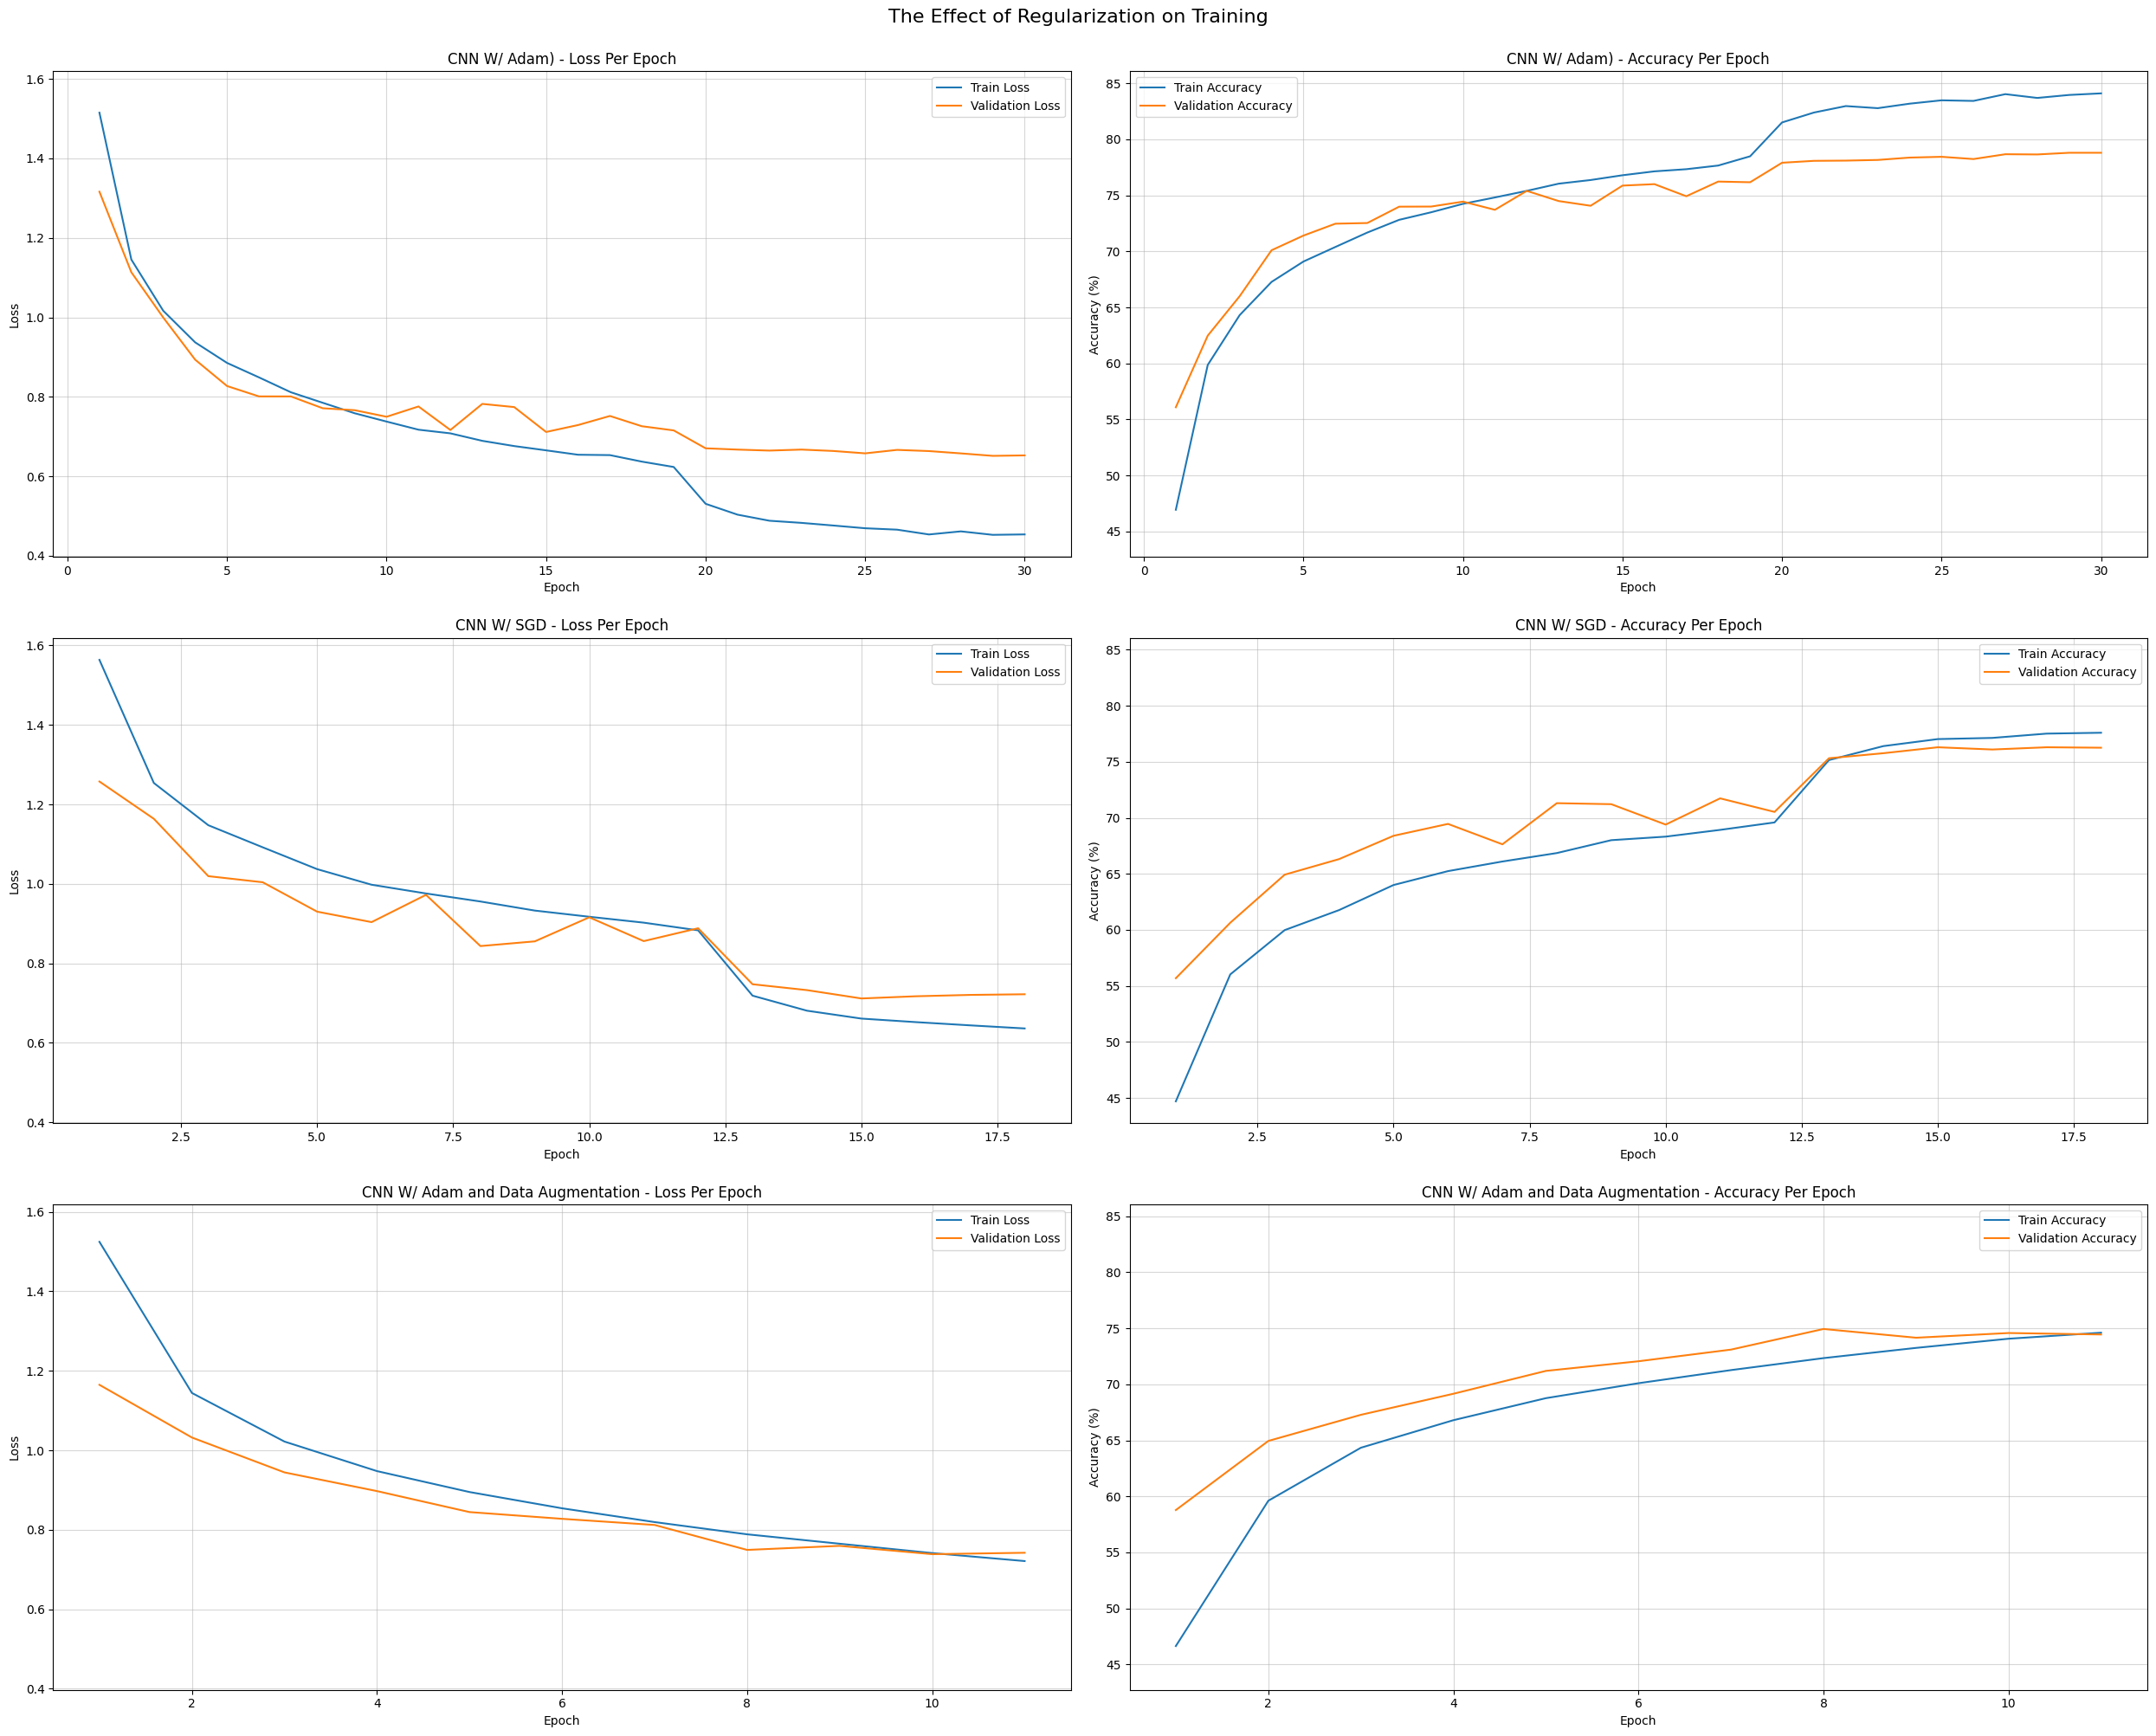

In [7]:
# Create figure with 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(25, 20))

# Data to plot (model metrics)
models_data = [
    (cnn_adam_model_metrics, "CNN W/ Adam)"),
    (cnn_sgd_model_metrics, "CNN W/ SGD"),
    (cnn_aug_model_metrics, "CNN W/ Adam and Data Augmentation")

]

# Precompute global min and max for loss and accuracy
all_losses = []
all_accuracies = []
for metrics, _ in models_data:
    all_losses.extend(metrics["train_loss_history"])
    all_losses.extend(metrics["val_loss_history"])
    all_accuracies.extend(metrics["train_acc_history"])
    all_accuracies.extend(metrics["val_acc_history"])

# Add 5% padding to the ranges
loss_padding = (max(all_losses) - min(all_losses)) * 0.05
acc_padding = (max(all_accuracies) - min(all_accuracies)) * 0.05

# Set consistent y-axis limits for all plots
for i in range(3):
    # Left column (loss plots)
    axes[i, 0].set_ylim(min(all_losses) - loss_padding, max(all_losses) + loss_padding)

    # Right column (accuracy plots)
    axes[i, 1].set_ylim(min(all_accuracies) - acc_padding, max(all_accuracies) + acc_padding)

# Create plots for each model
for i, (metrics, title) in enumerate(models_data):
    # Left plot (loss)
    ax_left = axes[i, 0]
    ax_left.set_title(f"{title} - Loss Per Epoch")
    ax_left.grid(True, alpha=0.5)
    ax_left.set_xlabel("Epoch")
    ax_left.set_ylabel("Loss")
    p1 = ax_left.plot(metrics["epochs"], metrics["train_loss_history"], label='Train Loss')
    p2 = ax_left.plot(metrics["epochs"], metrics["val_loss_history"], label='Validation Loss')
    ax_left.legend()

    # Right plot (accuracy)
    ax_right = axes[i, 1]
    ax_right.set_title(f"{title} - Accuracy Per Epoch")
    ax_right.grid(True, alpha=0.5)
    ax_right.set_xlabel("Epoch")
    ax_right.set_ylabel("Accuracy (%)")
    p3 = ax_right.plot(metrics["epochs"], metrics["train_acc_history"], label='Train Accuracy')
    p4 = ax_right.plot(metrics["epochs"], metrics["val_acc_history"], label='Validation Accuracy')
    ax_right.legend()

# Add overall title and adjust layout
fig.suptitle(f"The Effect of Regularization on Training",
             fontsize=16, y=1.0)
fig.tight_layout(h_pad=2.0, w_pad=1.5)

plt.show()